## MRI Brain Tumour Segmentation using U-Net Deep Learning Model

References:
- https://arxiv.org/pdf/1505.04597
- https://github.com/adityajn105/brain-tumor-segmentation-unet/blob/master/brain_tumor_segmentation.ipynb

### Import necessary libraries

In [2]:
import json
import matplotlib.pyplot as plt
import keras_tuner as kt

from utils import *
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Data Preperation

In [4]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 4 

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    validation_split=0.2,   # Split data into training and validation
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of image width
    height_shift_range=0.1, # Random vertical shift by up to 10% of image height
    zoom_range=0.1,         # Random zooming by up to 10%
    shear_range=0.2,
    horizontal_flip=True,   # Random horizontal flipping
    vertical_flip=True,     # Random vertical flipping
    # rotation_range=10,      # Random rotation up to 10 degrees
    # fill_mode='nearest',    # Fill mode for pixels outside the input boundaries,
)

# Create ImageDataGenerator for validation data
valid_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    validation_split=0.2    # Split data into training and validation
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19032024
)

# Create validation generator
validation_generator = valid_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19032024
)

# Check the shape of your training data
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break

Found 380 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 4)


In [5]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Training classes:", class_names)
class_names = list(validation_generator.class_indices.keys())
print("Validation classes:", class_names)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


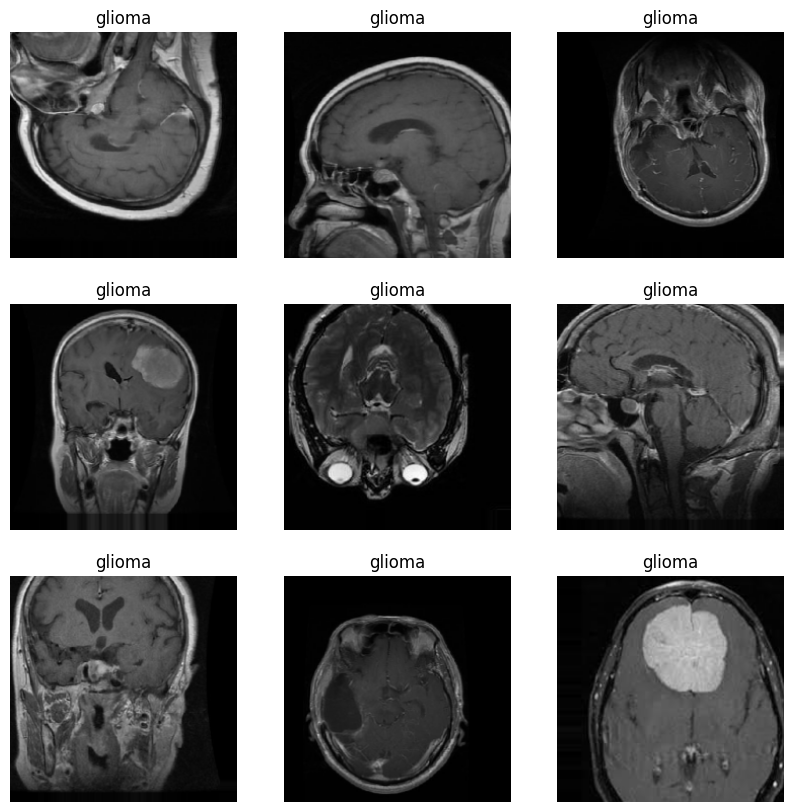

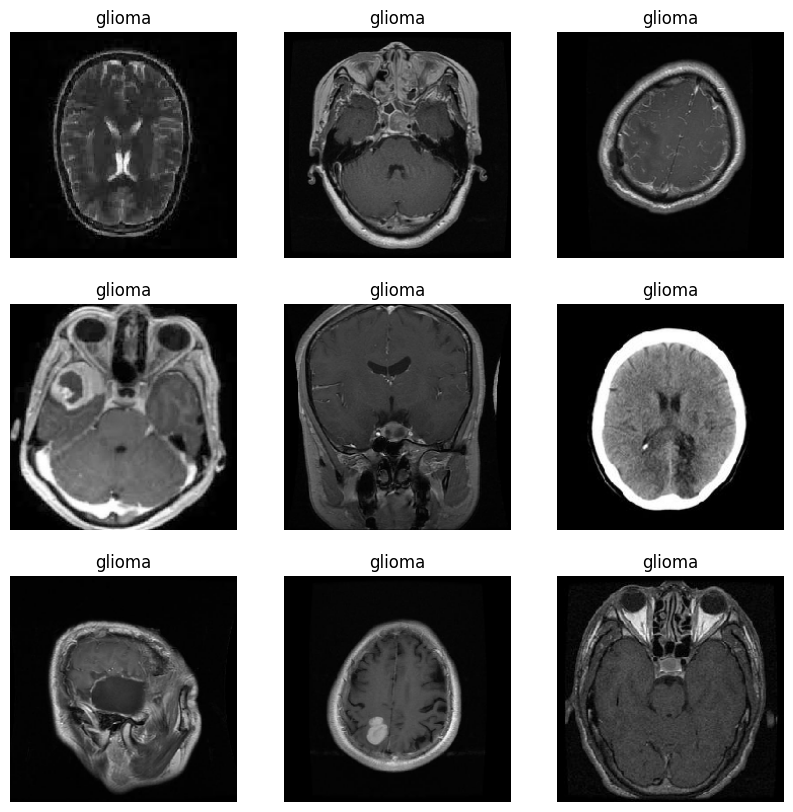

In [6]:
# Preview training dataset
sample_data_train = train_generator.__getitem__(1)[0]
sample_label_train = train_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_train[i])
    plt.title(class_names[np.argmax(sample_label_train[i].argmax())])
    plt.axis("off")

# Preview validation dataset
sample_data_validation = validation_generator.__getitem__(1)[0]
sample_label_validation = validation_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_validation[i])
    plt.title(class_names[np.argmax(sample_label_validation[i].argmax())])
    plt.axis("off")

### Model Creation

In [46]:
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH, 3)

def conv2d_block(input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  
# Input layer
inp = Input(shape=IMG_DIM)

# Encoder
d1 = conv2d_block(inp, 64, name="contraction_1")
p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block(p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block(p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

# Decoder
u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

# Final classification layer
flattened = Flatten()(c4)
out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)


unet = Model(inp, out)
unet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_1     │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_1_2     │ (None, 224, 224,  │     36,928 │ contraction_1_1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 112, 112,  │          0 │ contraction_1_2[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ max_pooling2d_16… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_1   │ (None, 112, 112,  │     73,856 │ dropout_32[0][0]  │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_2_1_2   │ (None, 112, 112,  │    147,584 │ contraction_2_1_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 56, 56,    │          0 │ contraction_2_1_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ max_pooling2d_17… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_1   │ (None, 56, 56,    │    295,168 │ dropout_33[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_3_1_2   │ (None, 56, 56,    │    590,080 │ contraction_3_1_… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 28, 28,    │          0 │ contraction_3_1_… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ max_pooling2d_18… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contraction_4_1_1   │ (None, 28, 28,    │  1,180,160 │ dropout_34[0][0]

 Total params: 35,564,676 (135.67 MB)

 Trainable params: 35,562,756 (135.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [47]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_initial_checkpoint.keras', 
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1,
                                   save_best_only=True
                                   )

# Compile the model
unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train the model
history = unet.fit(train_generator, 
                 epochs=20, 
                 validation_data=validation_generator, 
                 verbose=1, 
                 callbacks=[model_checkpoint]
                 )

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2543 - loss: 318.2301 
Epoch 1: val_accuracy improved from -inf to 0.24211, saving model to ./models/unet_initial_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 261s 21s/step - accuracy: 0.2556 - loss: 306.1951 - val_accuracy: 0.2421 - val_loss: 2.1106
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.2467 - loss: 3.0455 
Epoch 2: val_accuracy improved from 0.24211 to 0.26316, saving model to ./models/unet_initial_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 242s 20s/step - accuracy: 0.2500 - loss: 2.9730 - val_accuracy: 0.2632 - val_loss: 1.3813
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3309 - loss: 1.3630 
Epoch 3: val_accuracy improved from 0.26316 to 0.34737, saving model to ./models/unet_initial_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 240s 20s/step - accuracy: 0.3330 - loss: 1.3599 - val_accuracy: 0.3474 - val_loss: 1.3046
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy

In [48]:
unet.save(INITIAL_MODEL_FILE)
print(f"Model saved to {INITIAL_MODEL_FILE}")

Model saved to ./models/unet_initial_model.keras


### Initial Model Evaluation

In [18]:
unet = tf.keras.models.load_model("./models/unet_initial_checkpoint.keras")

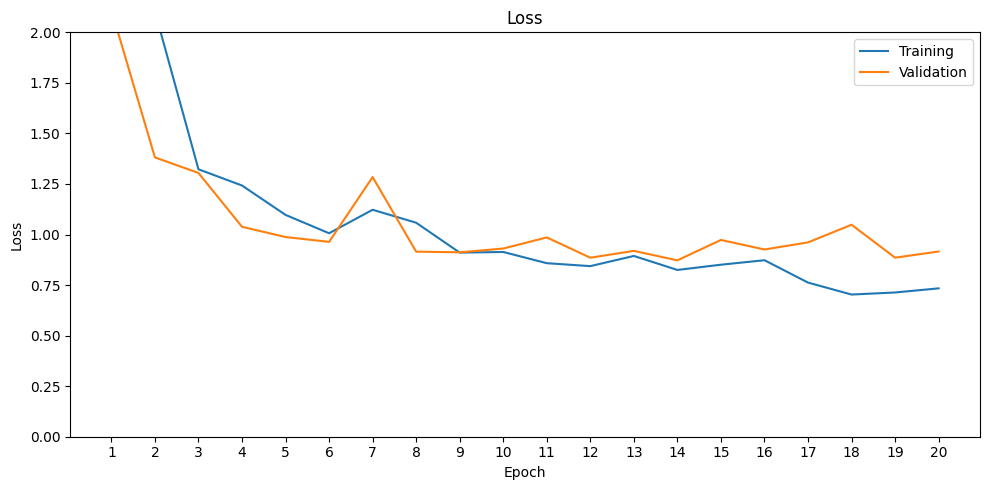

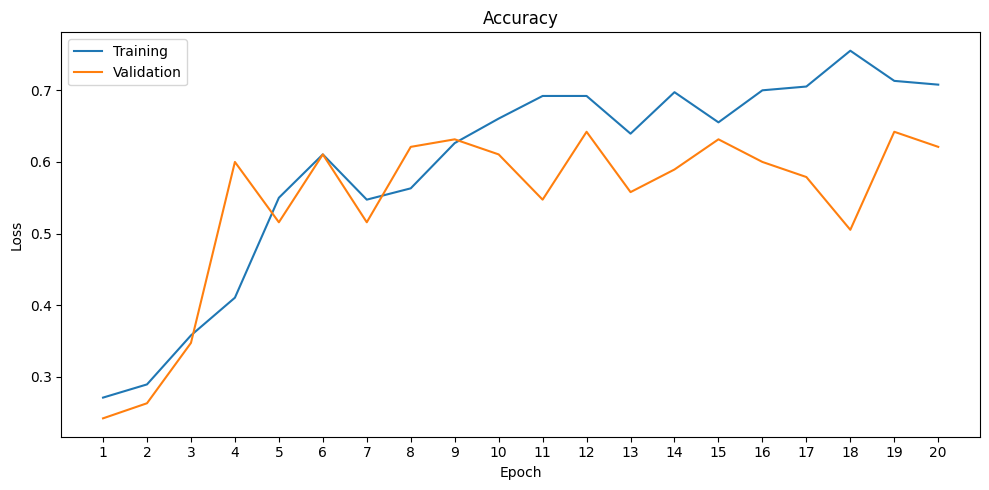

Training Results:
~Accuracy~
Max (best) accuracy: 0.7552631497383118 at epoch 18
Min (worst) accuracy: 0.27105262875556946 at epoch 1
Median accuracy: 0.6473684310913086
Mean accuracy: 0.5922368407249451

~Loss~
Min (best) loss: 0.7031980752944946 at epoch 18
Max (worst) loss: 161.77587890625 at epoch 1
Median loss: 0.9023089110851288
Mean loss: 9.030488613247872

~Final Training Performance~
Accuracy: 0.6421052813529968, Loss: 0.8853051662445068

Validation Results:
~Accuracy~
Max (best) accuracy: 0.6421052813529968 at epoch 12
Min (worst) accuracy: 0.24210526049137115 at epoch 1
Median accuracy: 0.5947368443012238
Mean accuracy: 0.543684209138155

~Loss~
Min (best) loss: 0.8723545074462891 at epoch 14
Max (worst) loss: 2.1106457710266113 at epoch 1
Median loss: 0.9624197483062744
Mean loss: 1.060045126080513

~Final Validation Performance~
Accuracy: 0.6421052813529968, Loss: 0.8853051662445068


In [50]:
def display_training_curves(training, validation, title, ylim=None):
    epochs = range(1, len(training) + 1)
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(epochs, training)
    plt.plot(epochs, validation)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    
    if ylim:
        plt.ylim(ylim)
    
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()

# Plot loss
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', ylim=(0, 2))

# Plot accuracy
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*unet.evaluate(validation_generator, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*unet.evaluate(validation_generator, verbose=0)))

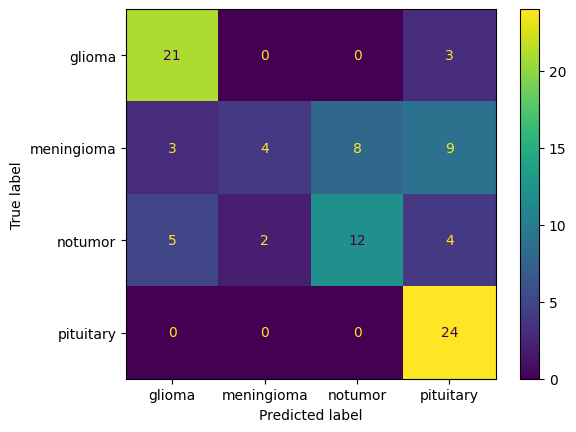

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = []
y_true = []
y_pred = []

class_names = train_generator.class_indices

labels = []
predictions = []
for batch_index in range(len(validation_generator)):
	images, lbls = next(validation_generator)
	preds = unet.predict(images, verbose=0)
	labels.extend(lbls)
	y_pred.extend(np.argmax(preds, axis=1))

y_true = np.argmax(labels, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [64]:
print("~Training Metrics~")
get_model_metrics(train_generator, unet, len(train_generator))

print("\n~Validation Metrics~")
get_model_metrics(validation_generator, unet, len(validation_generator))

~Training Metrics~
Accuracy: 0.6763157894736842
Precision: 0.6932396311689651
Recall: 0.6752357652693031
F1 Score: 0.6508524831029744
Matthews Correlation Coefficient (MCC): 0.5857268082367146
Cohen's Kappa: 0.567138054621732
Hamming Loss: 0.3236842105263158

Confusion Matrix:
 [[84  1  0  8]
 [34 29 11 25]
 [ 9 13 51 13]
 [ 8  1  0 93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.90      0.74        93
           1       0.66      0.29      0.41        99
           2       0.82      0.59      0.69        86
           3       0.67      0.91      0.77       102

    accuracy                           0.68       380
   macro avg       0.69      0.68      0.65       380
weighted avg       0.69      0.68      0.65       380




~Validation Metrics~
Accuracy: 0.6421052631578947
Precision: 0.6477011494252873
Recall: 0.6408514492753623
F1 Score: 0.5918147579347667
Matthews Correlation Coefficient (MCC): 0.5480148331318481
Co

### Model Fine Tuning

In [22]:
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH, 3)

def conv2d_block(input_tensor, n_filters, kernel_size=(3,3), name="contraction"):
    "Add 2 conv layers"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_2')(x)
    return x

def build_model(hp):
    inp = Input(shape=IMG_DIM)

    # Encoder
    d1 = conv2d_block(inp, hp.Int('filters_1', 32, 128, step=32), name="contraction_1")
    p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
    p1 = BatchNormalization(momentum=0.8)(p1)
    p1 = Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1))(p1)

    d2 = conv2d_block(p1, hp.Int('filters_2', 64, 256, step=64), name="contraction_2")
    p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d2)
    p2 = BatchNormalization(momentum=0.8)(p2)
    p2 = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(p2)

    d3 = conv2d_block(p2, hp.Int('filters_3', 128, 512, step=128), name="contraction_3")
    p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d3)
    p3 = BatchNormalization(momentum=0.8)(p3)
    p3 = Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1))(p3)

    d4 = conv2d_block(p3, hp.Int('filters_4', 256, 512, step=256), name="contraction_4")
    p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d4)
    p4 = BatchNormalization(momentum=0.8)(p4)
    p4 = Dropout(hp.Float('dropout_4', 0.1, 0.5, step=0.1))(p4)

    d5 = conv2d_block(p4, hp.Int('filters_5', 256, 512, step=256), name="contraction_5")

    # Decoder
    u1 = Conv2DTranspose(hp.Int('filters_5', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(d5)
    u1 = concatenate([u1, d4])
    u1 = Dropout(hp.Float('dropout_5', 0.1, 0.5, step=0.1))(u1)
    c1 = conv2d_block(u1, hp.Int('filters_4', 256, 512, step=256), name="expansion_1")

    u2 = Conv2DTranspose(hp.Int('filters_4', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(c1)
    u2 = concatenate([u2, d3])
    u2 = Dropout(hp.Float('dropout_4', 0.1, 0.5, step=0.1))(u2)
    c2 = conv2d_block(u2, hp.Int('filters_3', 128, 512, step=128), name="expansion_2")

    u3 = Conv2DTranspose(hp.Int('filters_3', 128, 512, step=128), (3, 3), strides=(2, 2), padding='same')(c2)
    u3 = concatenate([u3, d2])
    u3 = Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1))(u3)
    c3 = conv2d_block(u3, hp.Int('filters_2', 64, 256, step=64), name="expansion_3")

    u4 = Conv2DTranspose(hp.Int('filters_2', 64, 256, step=64), (3, 3), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, d1])
    u4 = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(u4)
    c4 = conv2d_block(u4, hp.Int('filters_1', 32, 128, step=32), name="expansion_4")

    # Final classification layer
    flattened = Flatten()(c4)
    out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)

    unet = Model(inp, out)

    unet.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

    return unet

# Test if the model builds successfully
build_model(kt.HyperParameters())

<Functional name=functional_5, built=True>

In [23]:
# Tuning settings
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory="hyperparameter-search",
                     project_name="brain-tumor-classification",
)

Reloading Tuner from hyperparameter-search/brain-tumor-classification/tuner0.json


In [ ]:
# Perform search
tuner.search(train_generator, 
             epochs=10, 
             validation_data=validation_generator
             )

In [24]:
# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"filters_1: {best_hps.get('filters_1')}")
print(f"dropout_1: {best_hps.get('dropout_1')}")
print(f"filters_2: {best_hps.get('filters_2')}")
print(f"dropout_2: {best_hps.get('dropout_2')}")
print(f"filters_3: {best_hps.get('filters_3')}")
print(f"dropout_3: {best_hps.get('dropout_3')}")
print(f"filters_4: {best_hps.get('filters_4')}")
print(f"dropout_4: {best_hps.get('dropout_4')}")
print(f"filters_5: {best_hps.get('filters_5')}")
print(f"dropout_5: {best_hps.get('dropout_5')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
filters_1: 96
dropout_1: 0.2
filters_2: 192
dropout_2: 0.1
filters_3: 512
dropout_3: 0.4
filters_4: 512
dropout_4: 0.30000000000000004
filters_5: 512
dropout_5: 0.5
learning_rate: 0.0009168824256071197


### Fine Tuned Model Training

In [25]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_tuned_checkpoint.keras', 
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1
                                   )
# reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Define callback list
callback_list = [model_checkpoint]

# Initialise the model with best hyperparameters
model_tuned = tuner.hypermodel.build(best_hps)

In [33]:
# Train the model
history_tuned = model_tuned.fit(train_generator, 
                                epochs=20, 
                                validation_data=validation_generator, 
                                verbose=1, 
                                callbacks=callback_list
                                )

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.3043 - loss: 713.7927 
Epoch 1: val_accuracy improved from -inf to 0.34737, saving model to ./models/unet_tuned_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 630s 52s/step - accuracy: 0.3026 - loss: 686.1623 - val_accuracy: 0.3474 - val_loss: 1.2498
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.3190 - loss: 1.5562 
Epoch 2: val_accuracy improved from 0.34737 to 0.47368, saving model to ./models/unet_tuned_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 616s 51s/step - accuracy: 0.3188 - loss: 1.5506 - val_accuracy: 0.4737 - val_loss: 1.2526
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 48s/step - accuracy: 0.3949 - loss: 1.2444 
Epoch 3: val_accuracy did not improve from 0.47368
12/12 ━━━━━━━━━━━━━━━━━━━━ 616s 52s/step - accuracy: 0.3973 - loss: 1.2415 - val_accuracy: 0.4526 - val_loss: 1.2294
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.4679 - loss: 1.2331 
Epoch 4: val_accuracy improved from 0.4

In [34]:
# Export tuned model
model_tuned.save(TUNED_MODEL_FILE)
print(f"Tuned model saved to {TUNED_MODEL_FILE}")

Tuned model saved to ./models/unet_tuned_model.keras


### Fine Tuned Model Evaluation

In [28]:
# Load the best tuned model
model_tuned = keras.models.load_model("./models/unet_tuned_checkpoint.keras")

In [ ]:
def display_training_curves(training, validation, title, ylim=None):
    epochs = range(1, len(training) + 1)
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(epochs, training)
    plt.plot(epochs, validation)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    
    if ylim:
        plt.ylim(ylim)
    
    plt.xticks(epochs)
    plt.tight_layout()
    plt.show()

# Plot loss
display_training_curves(history_tuned.history['loss'], history_tuned.history['val_loss'], 'Loss', ylim=(0, 2))

# Plot accuracy
display_training_curves(history_tuned.history['accuracy'], history_tuned.history['val_accuracy'], 'Accuracy')

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_tuned.history['accuracy']), "at epoch", history_tuned.history['accuracy'].index(max(history_tuned.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_tuned.history['accuracy']), "at epoch", history_tuned.history['accuracy'].index(min(history_tuned.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history_tuned.history['accuracy']))
print("Mean accuracy:", np.mean(history_tuned.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_tuned.history['loss']), "at epoch", history_tuned.history['loss'].index(min(history_tuned.history['loss'])) + 1)
print("Max (worst) loss:", max(history_tuned.history['loss']), "at epoch", history_tuned.history['loss'].index(max(history_tuned.history['loss'])) + 1)
print("Median loss:", np.median(history_tuned.history['loss']))
print("Mean loss:", np.mean(history_tuned.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_tuned.evaluate(validation_generator, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_tuned.history['val_accuracy']), "at epoch", history_tuned.history['val_accuracy'].index(max(history_tuned.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_tuned.history['val_accuracy']), "at epoch", history_tuned.history['val_accuracy'].index(min(history_tuned.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history_tuned.history['val_accuracy']))
print("Mean accuracy:", np.mean(history_tuned.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_tuned.history['val_loss']), "at epoch", history_tuned.history['val_loss'].index(min(history_tuned.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history_tuned.history['val_loss']), "at epoch", history_tuned.history['val_loss'].index(max(history_tuned.history['val_loss'])) + 1)
print("Median loss:", np.median(history_tuned.history['val_loss']))
print("Mean loss:", np.mean(history_tuned.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_tuned.evaluate(validation_generator, verbose=0)))

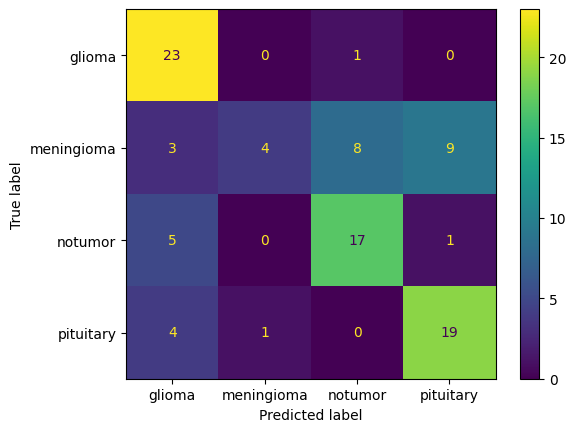

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = []
y_true = []
y_pred = []

class_names = train_generator.class_indices

labels = []
predictions = []
for batch_index in range(len(validation_generator)):
	images, lbls = next(validation_generator)
	preds = model_tuned.predict(images, verbose=0)
	labels.extend(lbls)
	y_pred.extend(np.argmax(preds, axis=1))

y_true = np.argmax(labels, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [31]:
# Function to compute performance of model
def get_model_metrics(dataset, model, num_batches):
    labels = []
    predictions = []
    for batch_index in range(num_batches):
        images, lbls = next(dataset)
        preds = model.predict(images, verbose=0)
        labels.extend(lbls)
        predictions.extend(np.argmax(preds, axis=1))
    
    y_true = np.argmax(labels, axis=1)
    classifier_metrics(y_true, predictions, print_results=True)
    
print("~Training Metrics~")
get_model_metrics(train_generator, model_tuned, len(train_generator))

print("\n~Validation Metrics~")
get_model_metrics(validation_generator, model_tuned, len(validation_generator))

~Training Metrics~
Accuracy: 0.7473684210526316
Precision: 0.7844487563698266
Recall: 0.7358150102400728
F1 Score: 0.7178520813530184
Matthews Correlation Coefficient (MCC): 0.6775486819749529
Cohen's Kappa: 0.6606448492064969
Hamming Loss: 0.25263157894736843

Confusion Matrix:
 [[95  0  0  7]
 [30 28 15 15]
 [10  1 75  8]
 [ 7  2  1 86]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.93      0.78       102
           1       0.90      0.32      0.47        88
           2       0.82      0.80      0.81        94
           3       0.74      0.90      0.81        96

    accuracy                           0.75       380
   macro avg       0.78      0.74      0.72       380
weighted avg       0.78      0.75      0.72       380




~Validation Metrics~
Accuracy: 0.6631578947368421
Precision: 0.6915403561955287
Recall: 0.6639492753623188
F1 Score: 0.6165954422526374
Matthews Correlation Coefficient (MCC): 0.5732938654542387


### K-Fold Cross-Validation

In [40]:
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Build the model
    model = tuner.hypermodel.build(best_hps)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 475 files belonging to 4 classes.


2024-07-11 00:26:11.213975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.5947368144989014, Loss: 1.0683647394180298
~Validation Dataset~
Accuracy: 0.6421052813529968, Loss: 1.029414415359497



KeyboardInterrupt: 

In [ ]:
# Convert labels to integer format if they are one-hot encoded
if len(labels.shape) > 1 and labels.shape[1] > 1:
    labels = np.argmax(labels, axis=1)

# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_skf_results = []

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32) / 255.0 
    label = tf.keras.utils.to_categorical(label, num_classes=NUM_CLASSES)
    return image, label

print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    model = tuner.hypermodel.build(best_hps)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1



Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.949999988079071, Loss: 0.21699199080467224
~Validation Dataset~
Accuracy: 0.7157894968986511, Loss: 1.2164653539657593

Fold Index 1
~Training Dataset~
Accuracy: 0.9868420958518982, Loss: 0.036468178033828735
~Validation Dataset~
Accuracy: 0.7052631378173828, Loss: 1.1485215425491333

Fold Index 2
~Training Dataset~
Accuracy: 1.0, Loss: 0.0019497951725497842
~Validation Dataset~
Accuracy: 0.6842105388641357, Loss: 1.71475350856781

Fold Index 3
~Training Dataset~
Accuracy: 0.9973683953285217, Loss: 0.016500765457749367
~Validation Dataset~
Accuracy: 0.6947368383407593, Loss: 1.481237530708313

Fold Index 4
~Training Dataset~
Accuracy: 1.0, Loss: 0.0027507992926985025
~Validation Dataset~
Accuracy: 0.6947368383407593, Loss: 1.4804081916809082



In [ ]:
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 0.9026315808296204,
        "median": 0.9894737005233765,
        "mean": 0.9747368454933166
    },
    "Training Loss": {
        "max": 0.3563303053379059,
        "min": 0.023520316928625107,
        "median": 0.06657510250806808,
        "mean": 0.10941840745508671
    },
    "Validation Accuracy": {
        "max": 0.7473683953285217,
        "min": 0.7052631378173828,
        "median": 0.7157894968986511,
        "mean": 0.7178947329521179
    },
    "Validation Loss": {
        "max": 5.726876258850098,
        "min": 1.494773507118225,
        "median": 1.987534999847412,
        "mean": 2.672141456604004
    }
}

Stratified K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 0.949999988079071,
        "median": 0.9973683953285217,
        "mean": 0.9868420958518982
    },
    "Training Loss": {
        "max": 0.21699199080467224,
        "m